# Montreal Downtown Crime Analytics

Project 1
<br>
Written by **Naga Satish Reddy Dwarampudi (40104630), Namita Faujdar(40105179)** 
<br>
For COMP 6721 **Section FI - Fall 2019**

In [407]:
"""imports which are used in the program"""
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import heapq
import time
import multiprocessing

In [408]:
def read_coordinates():
    
    """read coordinates method contains the four coordinates of the map"""
    map_boundary_latitude_points.append(45.49)#left_bottom
    map_boundary_longitude_points.append(check_lon)#left_bottom
    
    map_boundary_latitude_points.append(45.49)#right_bottom
    map_boundary_longitude_points.append(-73.55)#right_bottom
    
    map_boundary_latitude_points.append(check_lat)#top_right
    map_boundary_longitude_points.append(-73.55)#top_right
    
    map_boundary_latitude_points.append(check_lat)#top_left
    map_boundary_longitude_points.append(check_lon)#top_left

In [409]:
def generate_equal_space_values(points, grid_cell_size):
    """generate_equal_space_values used to split the latitude and 
            longitude points in equal space based on the grid cell size."""
    
    min_point, max_point = round(min(points),3), round(max(points), 3)
    steps = int((max_point - min_point) //grid_cell_size + 1)
    return np.linspace(min_point, max_point, steps)

In [410]:
def create_matrix_with_coordinates(longitude_array, latitude_array):
    """creates the matrix with coordiante values which is similar to the grid map generated"""
    
    coordinate_matrix = []
    latitude_list = latitude_array.tolist()
    latitude_list.reverse()
    for j in latitude_list:
        for i in longitude_array:
            coordinate_matrix.append([j,i])
    return np.array(coordinate_matrix)

In [411]:
def get_values_greater_than_threshold(H):
    """calculates and return the threshold value of the available crime points on the grid map"""
    
    threshold = int(threshold_value_given)
    a = H.reshape(1,-1)
    a.sort()
    value = a[0][int(threshold/100 * a.shape[1] - 1)]
    return round(value, 0)

In [412]:
def cost_of_the_edge(current_node, child, longitude_array, latitude_array):
    """checks the moment of the path and returns the cost of the path,
        if movnig diagonal returns 1.5
        if moving vertical or horizantal with a crime rate at one side then return 1.3
        if there is no crime rate on either side while moving vertical and horizantal then returns 1"""
    
    child_index = get_node_index(child, longitude_array, latitude_array)
    current_node_index = get_node_index(current_node, longitude_array, latitude_array)
    min_lat = min(child_index[0], current_node_index[0])
    min_lon = min(child_index[1], current_node_index[1])
    if child_index[0] == current_node_index[0]:
        if(min_lat- 1 >= 0 ):
            return 1 if (H[min_lat - 1][min_lon] == -1) and (H[min_lat][min_lon] == -1) else 1.3
    elif child_index[1] == current_node_index[1]:
        if(min_lon - 1 >=0):
            return  1 if (H[min_lat][min_lon - 1] == -1) and (H[min_lat][min_lon] == -1) else 1.3
    else:
        if H[min_lat][min_lon] == -1:
            return 1.5
    return 0

In [413]:
def calculate_heuristic(current_node, child, longitude_array, latitude_array):
    """heuristic method 'h' which calculates the distance between the two points"""
    
    return np.sqrt((current_node[0]-child[0])**2 + (current_node[1]-child[1])**2)

In [414]:
def get_all_valid_childs(destination, current_node, longitude_array, latitude_array, H, closed_list):
    """Finds the available child nodes for the current node and returns the valid nodes"""
    
    child_nodes = []
    neighbours = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    current_lon_index = longitude_array.index(current_node[0])
    current_lat_index = latitude_array.index(current_node[1])
    for neighbour_value in neighbours:
        child_lon_index = current_lon_index+neighbour_value[1]
        child_lat_index = current_lat_index+neighbour_value[0]
        if child_lon_index >= 0 and child_lon_index < len(longitude_array) and child_lat_index >= 0 and child_lat_index < len(latitude_array):
            child = (longitude_array[child_lon_index], latitude_array[child_lat_index])
            if child in closed_list:
                continue
            if child == destination and isNotCrimeArea(child, current_node, longitude_array, latitude_array, H):
                child_nodes.append(child)
            elif isValidChild(child, current_node, longitude_array, latitude_array, H):
                child_nodes.append(child)
    return child_nodes

In [415]:
def create_path(path, current_node):
    """creates the path list from the path map"""
    path_result.append(current_node)
    while current_node in path:
        current_node = path[current_node]
        path_result.append(current_node)
    return path_result

In [416]:
def find_path(source, destination, coordinate_matrix, H, longitude_array, latitude_array, grid_cell_size, isBonus = False):
    """finds the path of the from source to destination by checking the validity of nodes 
        and moves towards the other nodes by checking the heuristic value"""
    open_list = []
    closed_list = []
    g = {source:0}
    h = {source: 0}
    f_scores = {source: g[source] + h[source]}
    heapq.heappush(open_list, (f_scores[source], source, None))
    path = {}
    current_node = source
    while open_list:
        best_heuristic_child = heapq.heappop(open_list)
        current_node = best_heuristic_child[1]
        if(current_node == destination):
            break;
        if(current_node in closed_list):
            continue
        if best_heuristic_child[2] is not None:
            path[current_node] = best_heuristic_child[2]
        child_nodes = get_all_valid_childs(destination, current_node, longitude_array, latitude_array, H, closed_list);
        for child in child_nodes:
            path[child] = current_node
            cost = cost_of_the_edge(path[child],child, longitude_array, latitude_array)
            if not isBonus:
                g[child] = g[path[child]] + cost
            else:
                g[child] = 0
            h[child] = calculate_heuristic(child, destination, longitude_array, latitude_array)
            f_scores[child] = g[child]+h[child]
            heapq.heappush(open_list, (f_scores[child], child, current_node))
        closed_list.append(current_node)
    create_path(path, current_node)

In [417]:
def isValidChild(child, current_node,longitude_array, latitude_array, H):
    """checks whether the child is valid or not returns True if valid False otherwise"""
    if ischildBelongsToGrid(child, longitude_array, latitude_array) and notEdge(child, longitude_array, latitude_array) and isNotCrimeArea(child, current_node, longitude_array, latitude_array, H):
        return True
    return False

In [418]:
def ischildBelongsToGrid(child, longitude_array, latitude_array):
    """checks whether the current child belongs to the grid return True else returns False"""
    if (child[0] in longitude_array and child[1] in latitude_array):
        return True
    return False

In [419]:
def notEdge(child, longitude_array, latitude_array):
    """checks whether the current node is an edge or not if edge return False else return True"""
    longtitude_length = len(longitude_array) - 1
    latitude_length = len(latitude_array) - 1
    child_index = get_node_index(child, longitude_array, latitude_array)
    if child_index[0] != 0 and child_index[0] != latitude_length and child_index[1] != 0 and child_index[1] != longtitude_length:
        return True
    return False

In [420]:
def get_node_index(node, longitude_array, latitude_array):
    """returns the index of the coordinate in the grid"""
    return (latitude_array.index(node[1]), longitude_array.index(node[0]))

In [421]:
def isNotCrimeArea(child, current_node, longitude_array, latitude_array, H):
    """checks whether there is any crime rate or not in the path movement"""
    child_index = get_node_index(child, longitude_array, latitude_array)
    current_node_index = get_node_index(current_node, longitude_array, latitude_array)
    min_lat = min(child_index[0], current_node_index[0])
    min_lon = min(child_index[1], current_node_index[1])
    if child_index[0] == current_node_index[0]:
        if((min_lat- 1 >= 0 and H[min_lat - 1][min_lon] == -1) or (H[min_lat][min_lon] == -1)):
            return True
    elif child_index[1] == current_node_index[1]:
        if(min_lon - 1 >=0 and H[min_lat][min_lon - 1] == -1) or (H[min_lat][min_lon] == -1):
            return True
    else:
        if H[min_lat][min_lon] == -1:
            return True
    return False
    

Enter threshold75
Enter a grid cell size0.002
Crimes in Each Cell
 [[ 25.  10.  47.  94. 110.  29.  14.  16.   5.   6.  10.  43.   6.  18.
   12.  44.   5.   0.   0.   5.]
 [ 17.   0.  28. 105. 101. 101.  46.  60.  44.  12.  41.  19.  27.   8.
    4.  32.  40.   1.   1.   0.]
 [  9.   2.   2.  44. 210. 153.  83.  38. 123.  46.  28.  14.   6.  21.
   13.  20.   5.   1.  16.   0.]
 [  0.   1.   9.  23.  68. 165. 118.  85.  46. 121.  19.  40.   9.  19.
   16.  14.  16.   8.  52.   0.]
 [  0.   0. 224.  25.  48.  58. 234. 157. 164.  66.   6.  20.   6.  27.
   28.  65.  93.  30.  45.   0.]
 [  0.   0.   1.  35.  26.  45.  91. 128.  45. 178.  38.  53.  93.  35.
   40.  80. 108. 154.  36.   0.]
 [  0.   0.   0.   0.  22.  25.   0.  42.  15.  46. 312.  53.  69.  84.
   39. 190.  96.  98.   6.   0.]
 [  0.   0.   0.   0.   1.   0.  16.   0.  95.  90.  22. 105.  77.   6.
   49.  40. 253. 274.  98.   3.]
 [  0.   0.   0.   0.  63.  29.  77. 242.  45. 173. 146.  19.  68.  56.
  109.  84.  39.  20.

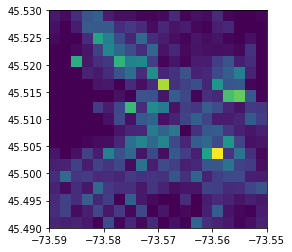

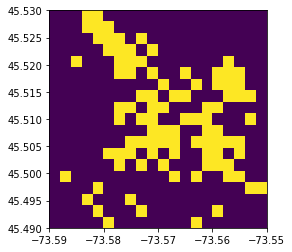

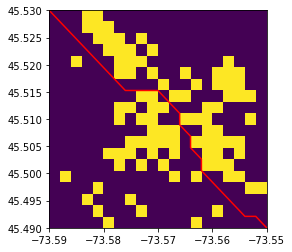

In [422]:
map_boundary_latitude_points = []
map_boundary_longitude_points = []
check_lon = -73.59
check_lat = 45.53
path_result = []
if __name__ == '__main__':
    """Point where program starts and creates the map and displays"""
    read_coordinates()
    threshold_value_given = int(input("Enter threshold"))
    grid_cell_size = float(input("Enter a grid cell size"))
    latitude_array = generate_equal_space_values(map_boundary_latitude_points, grid_cell_size)
    longitude_array = generate_equal_space_values(map_boundary_longitude_points, grid_cell_size)
    
    coordinate_matrix = create_matrix_with_coordinates(longitude_array, latitude_array)
    coordinate_matrix = coordinate_matrix.reshape(len(latitude_array), len(longitude_array), -1)
    
    geolocationData = gpd.read_file("Shape/crime_dt.shp")
    geometry = geolocationData['geometry']
    H,longitude_array_return, latitude_array_return = np.histogram2d(geolocationData['geometry'].y,geolocationData['geometry'].x, 
               bins=(latitude_array, longitude_array))
    
    plt.figure()
    plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
    
    print("Crimes in Each Cell\n", H)
    threshold_value = get_values_greater_than_threshold(H);
    print("Threshold_value", threshold_value)
    print("Mean", np.mean(H), "\nStandard Deviation", np.std(H), "\nTotal Crimes", np.sum(H))
    H[H <= threshold_value] = -1 #valid_route
    H[H > threshold_value] = 1 #in_valid_route
    
    plt.figure()
    plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
    
    longitude_array_list = longitude_array.tolist()
    latitude_array_list = latitude_array.tolist()
    latitude_array_list.reverse()
    
    source = (-73.55, 45.49)
    destination = (check_lon, check_lat)
    start_time = time.time()
    find_path(source, destination, coordinate_matrix, H, longitude_array_list, latitude_array_list, grid_cell_size);
    p = multiprocessing.Process(target=find_path, args=(source, destination, coordinate_matrix, H, longitude_array_list, latitude_array_list, grid_cell_size,))
    p.start()
    p.join(timeout=10)
    
    if p.is_alive():
        p.terminate()
        print("Due to timeout process terminated")
    else:
        print("Time taken", time.time()-start_time)
        if destination not in path:
            print("Due to blocks, no path is found. Please change the map and try again")
        else:
            path_result = np.array(path_result)
            cost = 0
            for i in range(1, len(path_result)):
                cost += cost_of_the_edge(path_result[i-1], path_result[i], longitude_array_list, latitude_array_list)
            print("Cost Caluculated", cost)
            plt.figure()
            plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
            plt.plot(path_result[:,0], path_result[:,1], color="red")

#Bonus 1

Enter threshold75
Enter a grid cell size0.002
Threshold_value
 71.0
Mean 50.026315789473685 
Standard Deviation 53.45789629138316 
Total Crimes 19010.0
Time taken 0.07181191444396973
First Heuristic Cost 32.5
Second Heuristic Cost 34.60000000000001


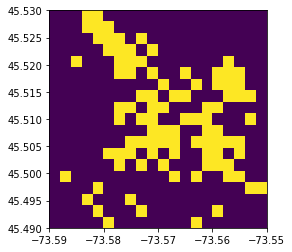

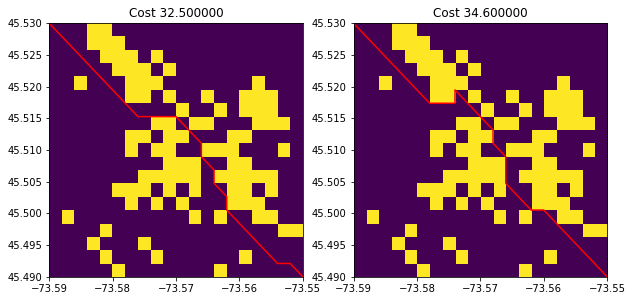

In [423]:
map_boundary_latitude_points = []
map_boundary_longitude_points = []
read_coordinates()
threshold_value_given = int(input("Enter threshold"))
grid_cell_size = float(input("Enter a grid cell size"))
latitude_array = generate_equal_space_values(map_boundary_latitude_points, grid_cell_size)
longitude_array = generate_equal_space_values(map_boundary_longitude_points, grid_cell_size)
    
coordinate_matrix = create_matrix_with_coordinates(longitude_array, latitude_array)
coordinate_matrix = coordinate_matrix.reshape(len(latitude_array), len(longitude_array), -1)
    
geolocationData = gpd.read_file("Shape/crime_dt.shp")
geometry = geolocationData['geometry']
H,longitude_array_return, latitude_array_return = np.histogram2d(geolocationData['geometry'].y,geolocationData['geometry'].x, 
            bins=(latitude_array, longitude_array))
threshold_value = get_values_greater_than_threshold(H);
print("Threshold_value\n", threshold_value)
print("Mean", np.mean(H), "\nStandard Deviation", np.std(H), "\nTotal Crimes", np.sum(H))
H[H <= threshold_value] = -1 #valid_route
H[H > threshold_value] = 1 #in_valid_route
    
plt.figure()
plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
    
longitude_array_list = longitude_array.tolist()
latitude_array_list = latitude_array.tolist()
latitude_array_list.reverse()
    
source = (-73.55, 45.49)
destination = (check_lon, check_lat)
start_time = time.time()
path_result = []
normal_path = [] 
find_path(source, destination, coordinate_matrix, H, longitude_array_list, latitude_array_list, grid_cell_size);
normal_path.extend(path_result)
path_result = []
bonus_path = []
find_path(source, destination, coordinate_matrix, H, longitude_array_list, latitude_array_list, grid_cell_size, True);
bonus_path.extend(path_result)
    
print("Time taken", time.time()-start_time)
if destination not in normal_path:
    print("Due to blocks, no path is found. Please change the map and try again by heuristic 1")
else:
    normal_path = np.array(normal_path)
    normal_cost = 0
    for i in range(1, len(normal_path)):
        normal_cost += cost_of_the_edge(normal_path[i-1], normal_path[i], longitude_array_list, latitude_array_list)
    print("First Heuristic Cost", normal_cost)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
    plt.plot(normal_path[:,0], normal_path[:,1], color="red")
    plt.title("Cost %f"%normal_cost)
if destination not in bonus_path:
    print("Due to blocks, no path is found. Please change the map and try again by heuristic 2")
else:
    bonus_path = np.array(bonus_path)
    bonus_cost = 0
    for i in range(1, len(bonus_path)):
        bonus_cost += cost_of_the_edge(bonus_path[i-1], bonus_path[i], longitude_array_list, latitude_array_list)
    print("Second Heuristic Cost", bonus_cost)
    plt.subplot(1,2,2)
    plt.imshow(H, extent=[longitude_array[0], longitude_array[-1], latitude_array[0], latitude_array[-1]])
    plt.plot(bonus_path[:,0], bonus_path[:,1], color="red")
    plt.title("Cost %f"%bonus_cost)